In [1]:
import os
import numpy as np
import pandas as pd

vmtable = pd.read_csv("trace_data/vmtable/vmtable.csv", header=None)
vmtable.columns = ["vm_id", "subscription_id", "deployment_id",
                   "timestamp_vm_created", "timestamp_vm_deleted",
                   "max_cpu", "avg_cpu", "p95_max_cpu", "vm_category",
                   "vm_virtual_core_count_bucket", "vm_memory_gb_bucket"]
vmtable.head()

,vm_id,subscription_id,deployment_id,timestamp_vm_created,timestamp_vm_deleted,max_cpu,avg_cpu,p95_max_cpu,vm_category,vm_virtual_core_count_bucket,vm_memory_gb_bucket
0,71fJw0x+SDRdAxKPwLyHZhTgQpYw2afS6tjJhfT6kHnmLH...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBCDr...,558300,1673700,91.776885,0.728879,20.759630,Delay-insensitive,8,32
1,rKggHO/04j31UFy65mDTwtjdMQL/G03xWfl3xGeiilB4/W...,ub4ty8ygwOECrIz7eaZ/9hDwnCsERvZ3nJJ03sDSpD85et...,+ZraIDUNaWYDZMBiBtZm7xSjr+j3zcHGjup1+wyKxHFmyJ...,424500,425400,37.879261,3.325358,37.879261,Unknown,4,32
2,YrR8gPtBmfNaOdnNEW5If1SdTqQgGQHEnLHGPjySt53bKW...,9LrdYRcUfGbmL2fFfLR/JUg2OTkjGRe3iluwIhDRPnPDPa...,GEyIElfPSFupze8T+T1niQMepeqG88VpLNuxUMyIDbz8VF...,1133100,1133700,0.304368,0.220553,0.304368,Unknown,4,32
3,xzQ++JF1UAkh70CDhmzkiOo+DQn+E2TLErCFKEmSswv1pl...,0XnZZ8sMN5HY+Yg+0dykYB5oenlgsrCpzpgFSvn/MX42Ze...,7aCQS6fPUw9rwCPiqvghk/WCEbMV3KgNJjA+sssdfY5Ybl...,0,2591400,98.573424,30.340054,98.212503,Interactive,2,4
4,vZEivnhabRmImDr+JqKqZnpIM3WxtypwoxjfjnklR/idyR...,HUGaZ+piPP4eHjycCBki2yq0raJywdzrVuriR6nQceH3hA...,/s/D5VtTQDxyS6wq7N/VQAMczx61Ny1Ut3a3iFmDSOCXxp...,228300,229800,82.581449,13.876299,82.581449,Unknown,2,4


In [2]:
# timestamp_vm_created가 n일치 미만인 VM만 선발
ndays = 1
nseconds = ndays * 86400
vmtable = vmtable.loc[vmtable["timestamp_vm_created"] < nseconds]
vmtable.reset_index(drop=True, inplace=True)

# vCPU, vMEM 추가
vmtable["vCPU"] = vmtable["vm_virtual_core_count_bucket"].map({"2":2, "4":4, "8":8, "12":12, "24":24, ">24":24})
vmtable["vMEM"] = vmtable["vm_memory_gb_bucket"].map({"2":2, "4":4, "8":8, "16":16, "32":32, "64":64, ">64":64})

# Unknown 제거
vmtable = vmtable.loc[vmtable["vm_category"].str.lower().ne("unknown")]
# avg_cpu가 10% 이상인 VM만 대상
vmtable = vmtable.loc[(vmtable["avg_cpu"] >= 10)]
# vmtable = vmtable.loc[(vmtable["avg_cpu"] >= 10) & (vmtable["vCPU"] <= 8)]

# 일부 VM만 sample
sample_n = 9
random_seed = 42

# sampling 가중치 조절
weights = np.ones(len(vmtable))
# is_started_on_0 = vmtable["timestamp_vm_created"] == 0
# is_on_demand_VM = vmtable["vm_category"].str.lower().eq("interactive")
# # t=0에서 시작하는 on-demand VM은 가중치를 낮게 줌
# weights[is_started_on_0 & is_on_demand_VM] = 0.1
# # t=0에서 시작하지 않는 on-demand VM은 가중치를 높게 줌
# weights[(~is_started_on_0) & is_on_demand_VM] = 10

vmtable = vmtable.sample(
    n=sample_n, 
    replace=False, 
    weights=weights,
    random_state=random_seed, 
    ignore_index=True
)

print("sample VM statistics")
print(f"t=0에서 시작하는 VM 비율: {(vmtable["timestamp_vm_created"] == 0).mean().item()*100:.2f}%")
print(f"on-demand VM 비율: {(vmtable["vm_category"].str.lower().eq("interactive")).mean().item()*100:.2f}%")
vmtable

sample VM statistics
t=0에서 시작하는 VM 비율: 100.00%
on-demand VM 비율: 44.44%


,vm_id,subscription_id,deployment_id,timestamp_vm_created,timestamp_vm_deleted,max_cpu,avg_cpu,p95_max_cpu,vm_category,vm_virtual_core_count_bucket,vm_memory_gb_bucket,vCPU,vMEM
0,FIXbi62wpCSXUcEVb/63GG2DKoW/p6WnLO+rByG/UQjvWF...,dAOosfZkO0HRXqD9V+N8ELMfPK/hggFmHHGyDY5GcOI29M...,o0+uEqNxcFSSS+DQsNcUoOwOAcVxw9LvC84OIEAA67OJ4T...,0,2591400,98.060127,28.170849,97.537540,Interactive,2,4,2,4
1,AsxRRWgUFuhj9EyZ8XRn2yI3RHuZMwUJk90ZjovJxVhbb8...,Q5HyfFx7U5/vEQE7BRWM/1wukBFsFuLd6TMG6aM+ro9yAf...,3WFfIy+zWtsy9yBF/7x7ZP6nr2vXK73pjX58npgWDtm4HH...,0,2591400,99.339313,16.309772,94.442341,Delay-insensitive,2,2,2,2
2,9ZLTb00Z47hfDZ0s2hy3IDxtMLGww2RLdcvXWBYHYBWc2c...,bZSsmpuk+qa2qxgqPtXlttPDCbVZDHkqGhOaSqVx9HZIoV...,GwPSiWgsx7APiTg6fl9mzOgDGCfieqcMe+KBAGtAC54jGH...,0,2591400,89.815949,41.645202,61.948429,Delay-insensitive,2,4,2,4
3,PcEG2hM12VkTd62RPFQZ94N260MN8s343fyh7WMHNXTO9q...,LoTNylwuP6YJ/K/2BREwrQNzP1tgu4rxliJN6EYwlQFzDh...,RPWWKP+nqEjX3e5d+e5SDG+PoOi+2545cmeeMJjWFg6aO3...,0,2591400,98.544483,13.441966,76.472707,Interactive,2,2,2,2
4,ijoBfJR0CggSbCZZVeog0iXfa004A2Yzu+PGIIfXQlRHgl...,tkimXgRlGhej7TBmV+J5dy9v7uRPQvHJwDSYAEJwpxN2pp...,4iELZ7oWUVTaFIwzywUeL6z2465LdCZut7b/8t6A9TQeeY...,0,2591400,92.945444,11.733387,64.631747,Delay-insensitive,2,2,2,2
5,VeFlyg2OBNhLcF26STv5OV08rETGpVdj6xegUbcLeE2H6y...,ioxaAePaQc2wsXil/5p1OJOAdHDrKcy1H0W1TVPGmPGNHW...,HYm8MTKjb/PRarK2/bQJAhQI/uh3UZRD4bDUBLQr6OwEx8...,0,2591400,97.828152,10.261847,65.316422,Delay-insensitive,2,2,2,2
6,XWRWBTprmdr8Ft7GxquqFb8cSMbgiGzXmYTheOlrr4f5Ve...,1wYls1fw1ahqoRuYgqTwW1CWwFCA+GhM8bUdE2ZnE3QEUi...,H7sClR+x5JuEla7XAQrY+ndhsycwQg/M3OuHdyyggOe4V6...,0,734100,97.092378,11.928122,88.500256,Interactive,2,4,2,4
7,lSIMt2cuq9kHazL4DQMLodfFZLlhg8Bo1gOcSejhsdLyn6...,eZAbvUup7GndVr0zzdsDw+oNnGPvLUp/avGwj+oKCQdZGL...,2JPib0ogbUG9QsKo1C0dBYI8ZP/8myG/hbFzc2RZ1Jjf5Q...,0,2591400,98.581799,26.564819,71.099162,Interactive,2,8,2,8
8,Hd2qO8VeEZzIP4PQQvarwa+UXMQPOEHmELKf3w08RWYGS6...,G7mIHbEmrCimNC4ODWGOavQ4MW7OuJ/BQGUcGHEq8Bsvnf...,xbKhRVhjA+HB6xl2RdhCoemtIvmtm2P70qE8agpuE64RD5...,0,2591400,99.465784,15.235571,57.502984,Delay-insensitive,4,8,4,8


In [3]:
from tqdm.notebook import trange

cpu_readings_path = "trace_data/vm_cpu_readings/"
fname = "vm_cpu_readings-file-{}-of-195.csv.gz"
sample_vm_id = vmtable['vm_id']

sample_vm_data = []
for i in trange(1, len(os.listdir(cpu_readings_path))+1):
    file_path = os.path.join(cpu_readings_path, fname.format(i))
    df = pd.read_csv(file_path, header=None, compression="gzip")
    df.columns = ["timestamp", "vm_id", "min_cpu", "max_cpu", "avg_cpu"]

    sample_vm_df = df.loc[df['vm_id'].isin(sample_vm_id)]
    sample_vm_df.reset_index(drop=True, inplace=True)
    
    sample_vm_data.append(sample_vm_df)
    del df
    
    if sample_vm_df["timestamp"].max() >= nseconds:
        break

sample_vm_df = pd.concat(sample_vm_data, axis=0, ignore_index=True)
sample_vm_df = sample_vm_df.loc[sample_vm_df["timestamp"] < nseconds]
sample_vm_df

  0%|          | 0/24 [00:00<?, ?it/s]

,timestamp,vm_id,min_cpu,max_cpu,avg_cpu
0,0,XWRWBTprmdr8Ft7GxquqFb8cSMbgiGzXmYTheOlrr4f5Ve...,1.142804,3.125540,1.508015
1,0,9ZLTb00Z47hfDZ0s2hy3IDxtMLGww2RLdcvXWBYHYBWc2c...,0.738101,2.657885,1.208934
2,0,FIXbi62wpCSXUcEVb/63GG2DKoW/p6WnLO+rByG/UQjvWF...,19.693575,22.401350,20.829815
3,0,AsxRRWgUFuhj9EyZ8XRn2yI3RHuZMwUJk90ZjovJxVhbb8...,4.614076,11.982517,6.819586
4,0,PcEG2hM12VkTd62RPFQZ94N260MN8s343fyh7WMHNXTO9q...,8.527495,10.324807,9.597361
...,...,...,...,...,...
2560,86100,AsxRRWgUFuhj9EyZ8XRn2yI3RHuZMwUJk90ZjovJxVhbb8...,5.040659,31.725765,9.330652
2561,86100,FIXbi62wpCSXUcEVb/63GG2DKoW/p6WnLO+rByG/UQjvWF...,19.758795,22.685708,21.054640
2562,86100,lSIMt2cuq9kHazL4DQMLodfFZLlhg8Bo1gOcSejhsdLyn6...,6.938681,26.407342,16.294748
2563,86100,9ZLTb00Z47hfDZ0s2hy3IDxtMLGww2RLdcvXWBYHYBWc2c...,31.969192,50.949426,41.373699


In [4]:
# 1시간 + vm_id 집계
sample_vm_df["timestamp"] = sample_vm_df["timestamp"] // 3600

sample_vm_df = (
    sample_vm_df
    .groupby(["vm_id", "timestamp"], as_index=False)
    .agg(
        min_cpu=("min_cpu", "min"),
        avg_cpu=("avg_cpu", "mean"),
        max_avg_cpu=("avg_cpu", "max"),
        max_cpu=("max_cpu", "max"),
    )
)

# vCPU 개수 join
sample_vm_df = sample_vm_df.merge(
    vmtable[["vm_id", "vCPU", "vm_category"]],
    on="vm_id",
    how="left"
)

# core 사용량 계산
sample_vm_df["min_core_usage"] = sample_vm_df["min_cpu"] * sample_vm_df["vCPU"] / 100
sample_vm_df["avg_core_usage"] = sample_vm_df["avg_cpu"] * sample_vm_df["vCPU"] / 100
sample_vm_df["max_avg_core_usage"] = sample_vm_df["max_avg_cpu"] * sample_vm_df["vCPU"] / 100
sample_vm_df["max_core_usage"] = sample_vm_df["max_cpu"] * sample_vm_df["vCPU"] / 100

sample_vm_df

,vm_id,timestamp,min_cpu,avg_cpu,max_avg_cpu,max_cpu,vCPU,vm_category,min_core_usage,avg_core_usage,max_avg_core_usage,max_core_usage
0,9ZLTb00Z47hfDZ0s2hy3IDxtMLGww2RLdcvXWBYHYBWc2c...,0,0.672509,1.239094,2.432777,8.072619,2,Delay-insensitive,0.013450,0.024782,0.048656,0.161452
1,9ZLTb00Z47hfDZ0s2hy3IDxtMLGww2RLdcvXWBYHYBWc2c...,1,0.673908,1.898868,5.303702,28.246261,2,Delay-insensitive,0.013478,0.037977,0.106074,0.564925
2,9ZLTb00Z47hfDZ0s2hy3IDxtMLGww2RLdcvXWBYHYBWc2c...,2,0.666265,1.237352,2.334294,8.346915,2,Delay-insensitive,0.013325,0.024747,0.046686,0.166938
3,9ZLTb00Z47hfDZ0s2hy3IDxtMLGww2RLdcvXWBYHYBWc2c...,3,0.667036,1.286585,2.381045,8.184768,2,Delay-insensitive,0.013341,0.025732,0.047621,0.163695
4,9ZLTb00Z47hfDZ0s2hy3IDxtMLGww2RLdcvXWBYHYBWc2c...,4,0.672907,1.151142,1.476706,5.630045,2,Delay-insensitive,0.013458,0.023023,0.029534,0.112601
...,...,...,...,...,...,...,...,...,...,...,...,...
211,lSIMt2cuq9kHazL4DQMLodfFZLlhg8Bo1gOcSejhsdLyn6...,19,14.963488,34.339008,37.403522,58.769448,2,Interactive,0.299270,0.686780,0.748070,1.175389
212,lSIMt2cuq9kHazL4DQMLodfFZLlhg8Bo1gOcSejhsdLyn6...,20,13.748139,28.499821,31.825852,47.215165,2,Interactive,0.274963,0.569996,0.636517,0.944303
213,lSIMt2cuq9kHazL4DQMLodfFZLlhg8Bo1gOcSejhsdLyn6...,21,11.115959,23.962341,28.586970,42.653981,2,Interactive,0.222319,0.479247,0.571739,0.853080
214,lSIMt2cuq9kHazL4DQMLodfFZLlhg8Bo1gOcSejhsdLyn6...,22,6.165415,19.489575,23.722003,50.692630,2,Interactive,0.123308,0.389792,0.474440,1.013853


In [5]:
sample_vm_df.to_csv("sample_vm_data.csv", index=False)

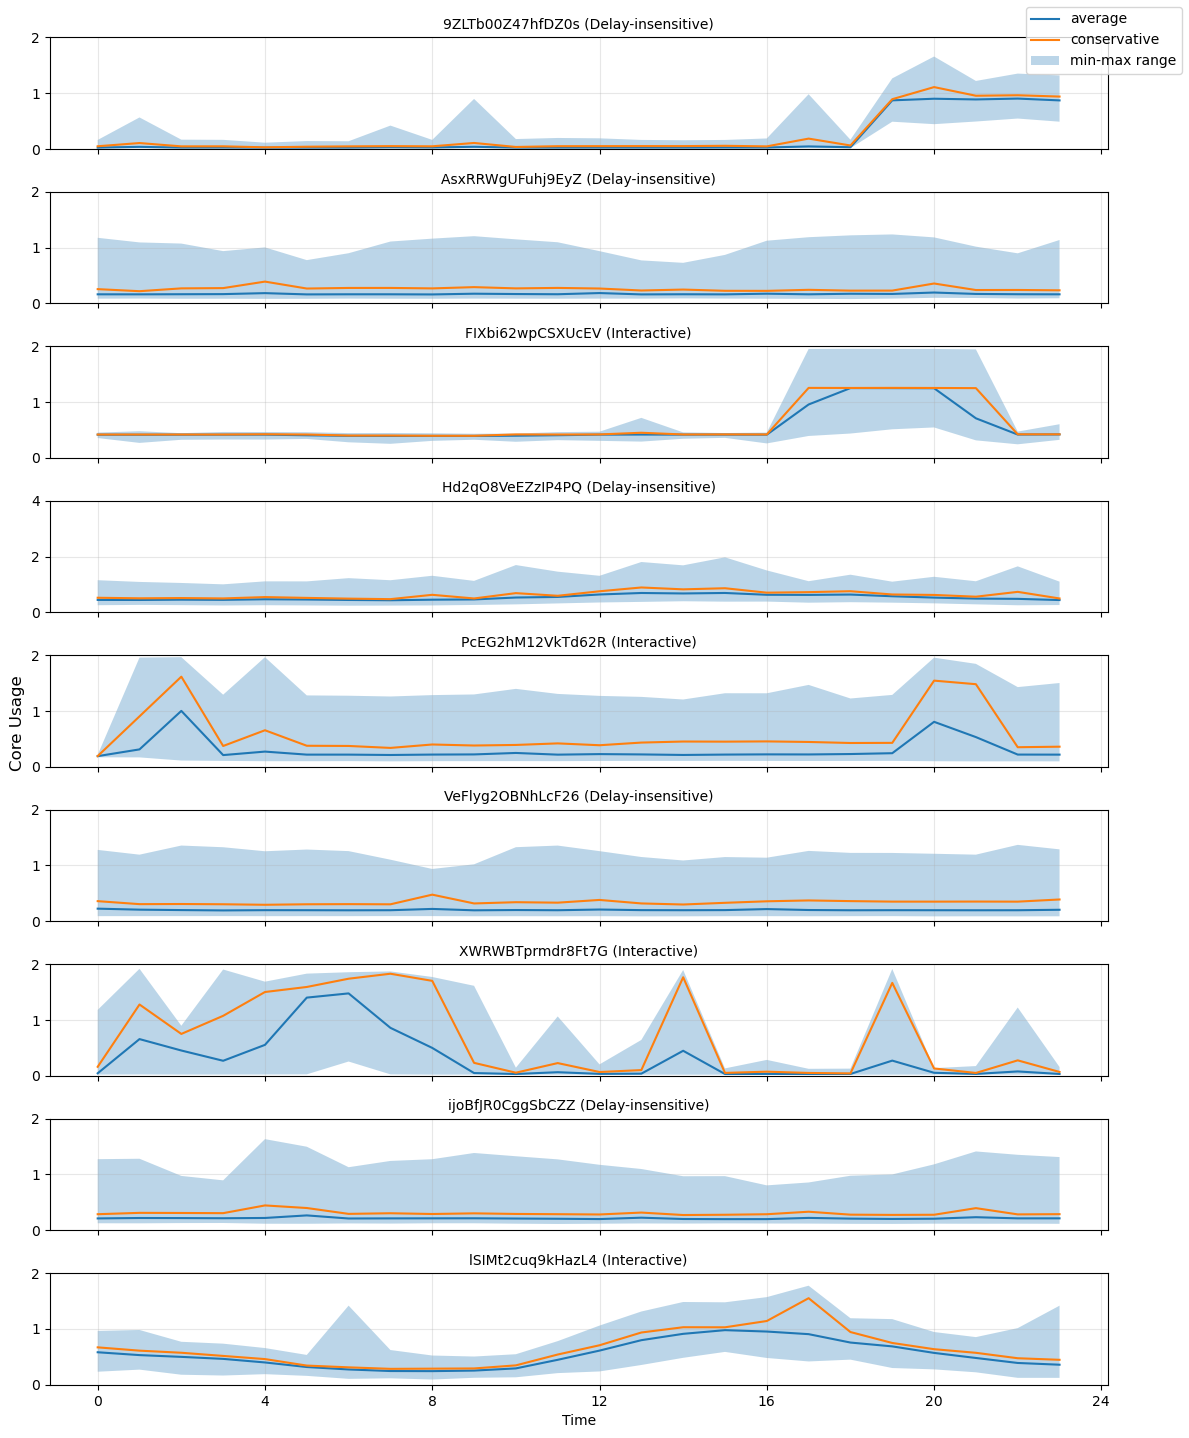

In [6]:
import matplotlib.pyplot as plt

def plot_mean_min_max_all(
    df,
    time_col='timestamp',
    mean_col='avg_core_usage',
    conserv_mean_col='max_avg_core_usage',
    min_col='min_core_usage',
    max_col='max_core_usage'
):
    vm_ids = df["vm_id"].unique()
    n_vm = len(vm_ids)

    fig, axes = plt.subplots(
        n_vm, 1,
        figsize=(12, 1.6 * n_vm),
        sharex=True
    )

    if n_vm == 1:
        axes = [axes]

    for ax, vm_id in zip(axes, vm_ids):
        g = df[df["vm_id"] == vm_id]

        ax.plot(g[time_col], g[mean_col], label='average')
        ax.plot(g[time_col], g[conserv_mean_col], label='conservative')
        ax.fill_between(
            g[time_col],
            g[min_col],
            g[max_col],
            alpha=0.3,
            label='min-max range'
        )

        vm_category = g["vm_category"].iloc[0]
        vcpu = g["vCPU"].iloc[0]

        ax.set_title(f"{vm_id[:16]} ({vm_category})", fontsize=10)
        ax.set_ylim(0, vcpu)
        ax.set_xticks(list(range(0, 25, 4)))
        ax.set_yticks([0, vcpu//2, vcpu])

        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Time")
    fig.supylabel("Core Usage")

    # legend는 한 번만
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    fig.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()

plot_mean_min_max_all(sample_vm_df)